In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import keras
from numpy import random
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.optimizers import Adam
from keras.layers import MaxPooling2D, BatchNormalization
from keras.optimizers import SGD
#from keras.utils import np_utils
from keras.applications import MobileNet, VGG16, ResNet50,DenseNet201,InceptionV3,EfficientNetB7
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report ,confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tabulate import tabulate
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Directory of train, validation and test

train_folder = "/content/drive/MyDrive/archive (1)/Data/train"
valid_folder = "/content/drive/MyDrive/archive (1)/Data/valid"
test_folder = "/content/drive/MyDrive/archive (1)/Data/test"


In [ ]:
print("\n\n\t\tTraining Set")
print("\t  ========================\n")
train_c = []
for folder in os.listdir(train_folder):
    train_c.append(folder)
    print("\nTrain "+ folder + " Class: ", len(os.listdir(train_folder + '/' + folder)))

print("\n\n", train_c)

print("\n\n\t\tTesting Set")
print("\t  ========================\n")
test_c = []
for folder in os.listdir(test_folder):
    test_c.append(folder)
    print("\nTest "+ folder + " Class: ", len(os.listdir(test_folder + '/' + folder)))

print("\n\n", test_c)

print("\n\n\t\tValidation Set")
print("\t  ========================\n")
val_c = []
for folder in os.listdir(valid_folder):
    val_c.append(folder)
    print("\nValidation "+ folder + " Class: ", len(os.listdir(valid_folder + '/' + folder)))

print("\n\n", val_c, "\n")



		Training Set


Train adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib Class:  195

Train large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa Class:  115

Train squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa Class:  155

Train normal Class:  148


 ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa', 'normal']


		Testing Set


Test squamous.cell.carcinoma Class:  90

Test normal Class:  54

Test large.cell.carcinoma Class:  51

Test adenocarcinoma Class:  120


 ['squamous.cell.carcinoma', 'normal', 'large.cell.carcinoma', 'adenocarcinoma']


		Validation Set


Validation large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa Class:  21

Validation adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib Class:  23

Validation normal Class:  13

Validation squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa Class:  15


 ['large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'normal'

In [ ]:
input_shape = (224,224,3)
num_class = 4

train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)

val_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,
)
test_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,
)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
)


test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle = False,
)
validation_generator = val_datagen.flow_from_directory(
    valid_folder,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
)

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


In [ ]:
#Defining a Checkpoint
checkpoint = ModelCheckpoint(filepath = 'C_CT_S.h5',
                            monitor = 'val_accuracy',
                            mode = 'max',
                            save_best_only = True,
                            verbose = 1)

#Defining a Early Stopping
earlystop = EarlyStopping(monitor = 'val_accuracy',
                         min_delta = .5,
                         patience = 5,
                         restore_best_weights = True)

#Defining LR Reducing rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                             factor = 0.1,
                             patience = 3,
                             verbose = 1,
                             min_delta = 0.8)

#Putting the call backs in a callback list
callbacks = [earlystop, reduce_lr]

In [ ]:
model = Sequential([
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),

    Flatten(),
    Dense(units=64, activation='relu'),
    Dropout(0.25),

    Dense(units=4, activation='softmax')
])


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_19 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 batch_normalization_6 (Bat  (None, 112, 112, 64)      256       
 chNormalization)                                                
                                                                 
 conv2d_20 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_21 (Conv2D)          (None, 112, 112, 128)    

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
epochs = 300

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    verbose=1
)
test = test_generator
score = model.evaluate(test, verbose = 1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epoch 1/300
20/20 [==============================] - 31s 773ms/step - loss: 1.5875 - accuracy: 0.4372 - val_loss: 1.7370 - val_accuracy: 0.1806
Epoch 2/300
20/20 [==============================] - 16s 772ms/step - loss: 1.0455 - accuracy: 0.4976 - val_loss: 1.4263 - val_accuracy: 0.1806
Epoch 3/300
20/20 [==============================] - 15s 760ms/step - loss: 0.9618 - accuracy: 0.5334 - val_loss: 1.6151 - val_accuracy: 0.1806
Epoch 4/300
20/20 [==============================] - 15s 754ms/step - loss: 0.9143 - accuracy: 0.5530 - val_loss: 1.4383 - val_accuracy: 0.1806
Epoch 5/300
20/20 [==============================] - 15s 767ms/step - loss: 0.9212 - accuracy: 0.5791 - val_loss: 1.3990 - val_accuracy: 0.2778
Epoch 6/300
20/20 [==============================] - 15s 760ms/step - loss: 0.8695 - accuracy: 0.6052 - val_loss: 1.1812 - val_accuracy: 0.3333
Epoch 7/300
20/20 [==============================] - 15s 762ms/step - loss: 0.8591 - accuracy: 0.6166 - val_loss: 1.0646 - val_accuracy:

In [ ]:
model.save("/content/drive/MyDrive/archive (1)/modelcustom.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
num_test_samples = len(test_generator)
num_classes = len(test_generator.class_indices)

predicted_probabilities = model.predict(test_generator, steps=num_test_samples)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

true_labels = test_generator.classes

report = classification_report(true_labels, predicted_labels)

print(report)

10/10 [==============================] - 3s 242ms/step
              precision    recall  f1-score   support

           0       0.94      0.84      0.89       120
           1       0.57      1.00      0.72        51
           2       1.00      0.98      0.99        54
           3       0.98      0.70      0.82        90

    accuracy                           0.85       315
   macro avg       0.87      0.88      0.85       315
weighted avg       0.90      0.85      0.86       315





Confusion Matrix:
 [[101  18   0   1]
 [  0  51   0   0]
 [  1   0  53   0]
 [  6  21   0  63]]


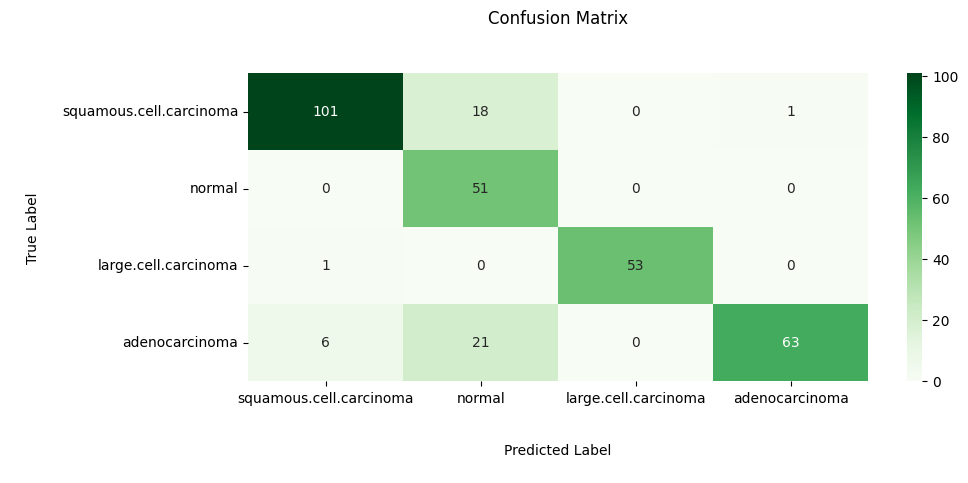

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)
print("\n\nConfusion Matrix:\n", cm)

plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', xticklabels = test_c, yticklabels = test_c)
plt.xlabel('\n\nPredicted Label\n')
plt.ylabel('\nTrue Label\n')
plt.title('Confusion Matrix\n\n')
plt.show()




Confusion Matrix:
 [[101  18   0   1]
 [  0  51   0   0]
 [  1   0  53   0]
 [  6  21   0  63]]


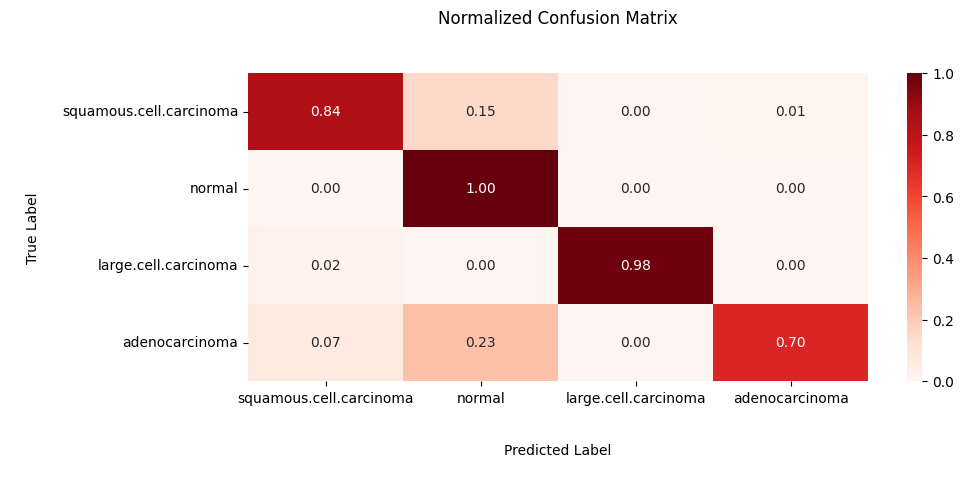

In [ ]:
# Assuming true_labels and predicted_labels are your actual and predicted labels, respectively
cm = confusion_matrix(true_labels, predicted_labels)

# Calculate normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print("\n\nConfusion Matrix:\n", cm)

plt.figure(figsize=(10, 4))

# Plot normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Reds', xticklabels=test_c, yticklabels=test_c)

plt.xlabel('\n\nPredicted Label\n')
plt.ylabel('\nTrue Label\n')
plt.title('Normalized Confusion Matrix\n\n')
plt.show()

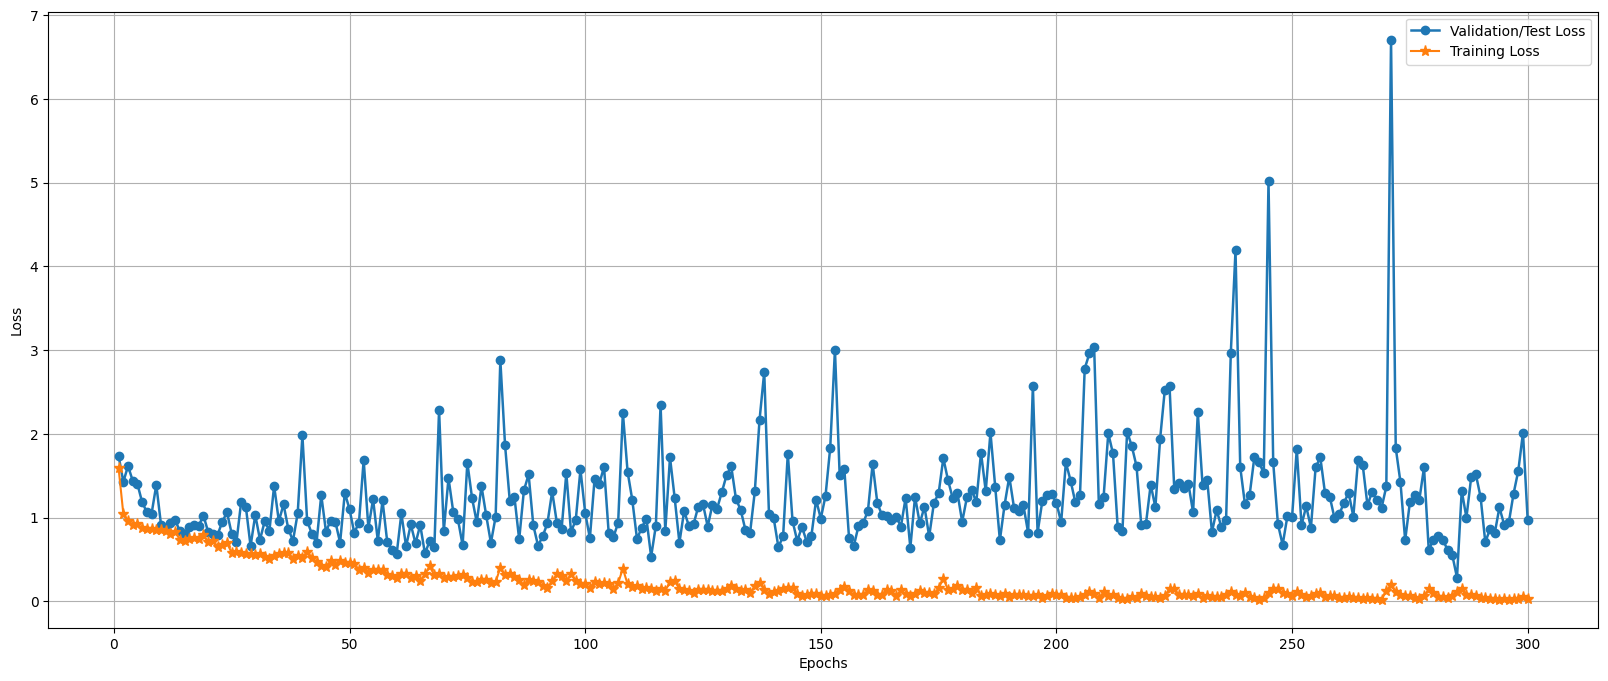

In [ ]:
#Plotting the loss charts

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.figure(figsize=(20,8))
line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.0)
plt.setp(line2, linewidth = 1.5, marker = '*', markersize = 8.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

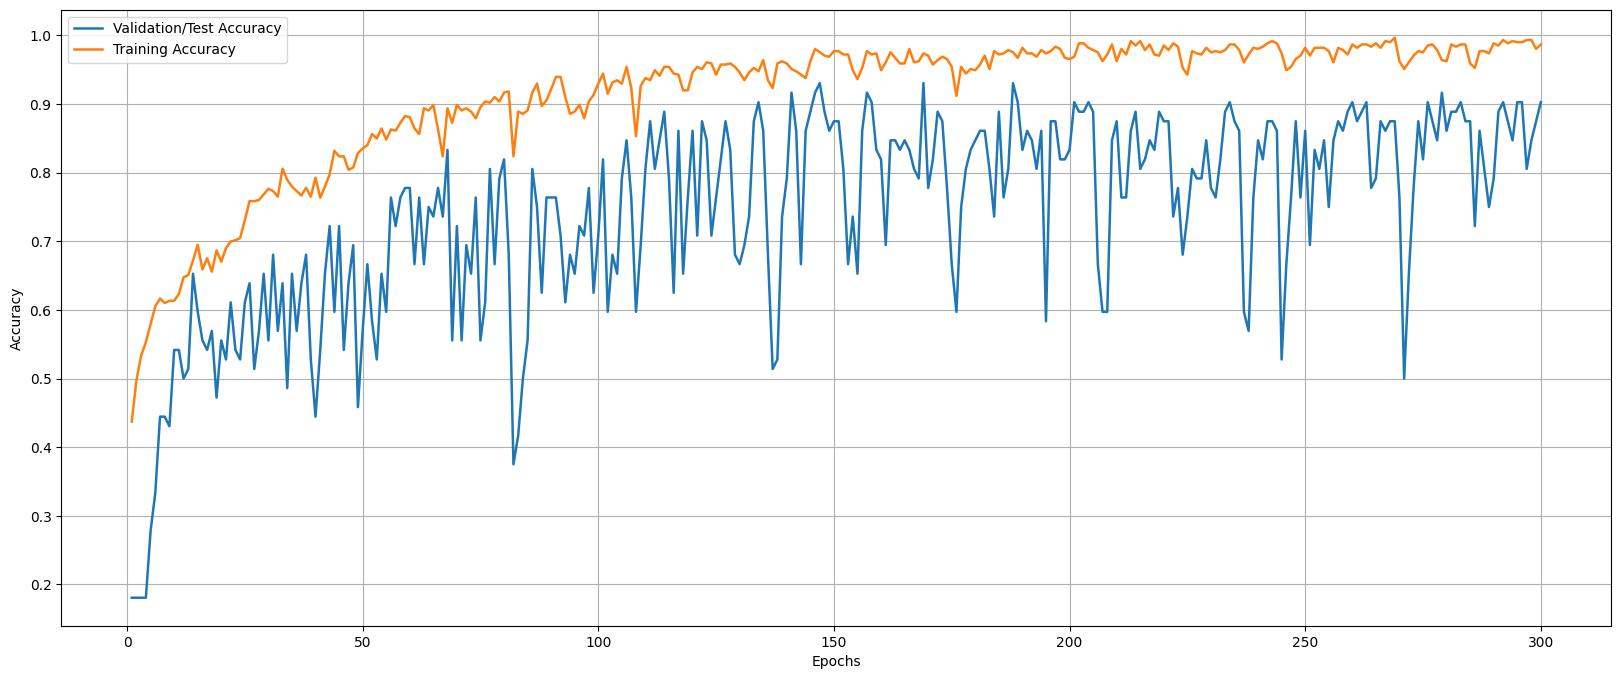

In [ ]:
#Plotting the accuracy charts

history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

plt.figure(figsize=(20,8))
line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

plt.setp(line1, linewidth = 1.8)
plt.setp(line2, linewidth = 1.8)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

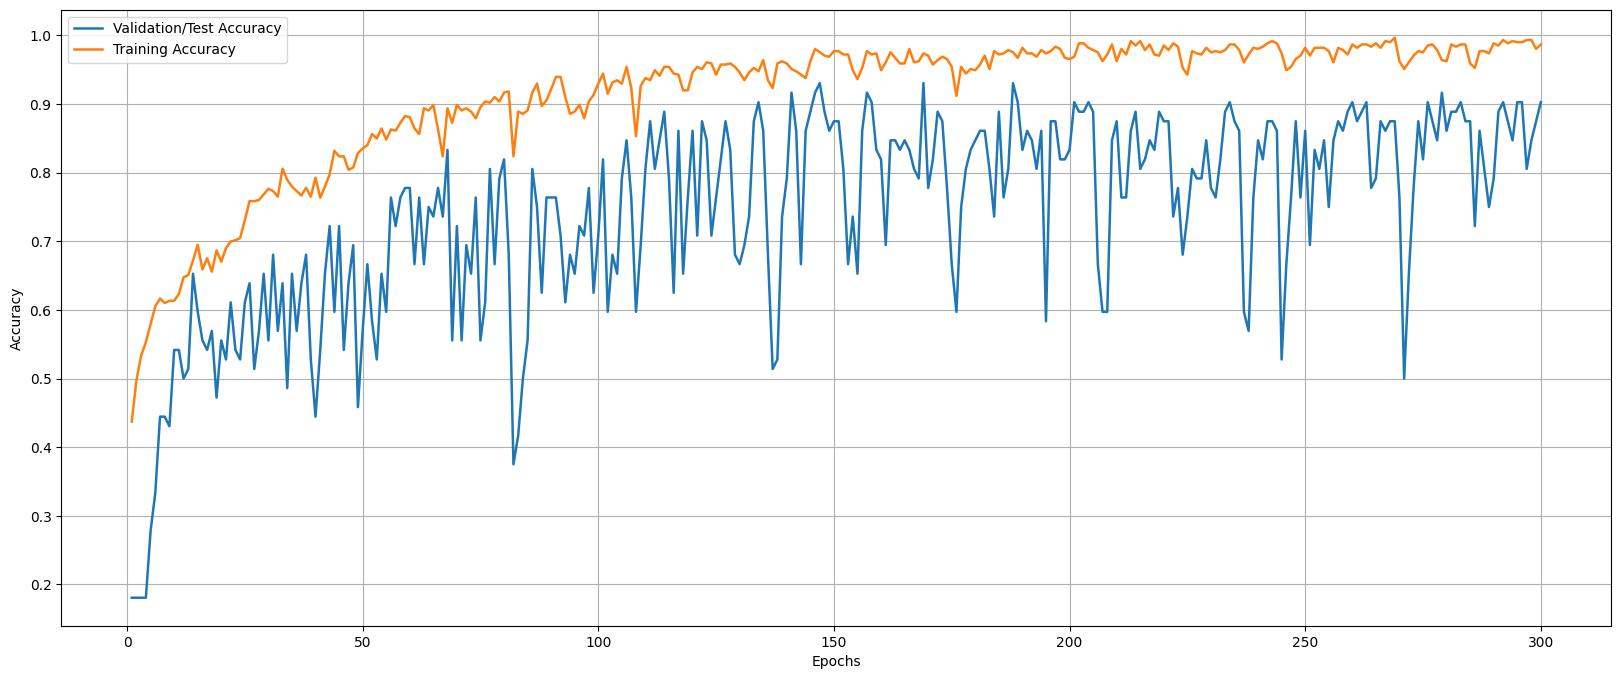

In [ ]:
#Plotting the accuracy charts

history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

plt.figure(figsize=(20,8))
line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

plt.setp(line1, linewidth = 1.8)
plt.setp(line2, linewidth = 1.8)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

-------------------------------------------------- Recall Matrix --------------------------------------------------


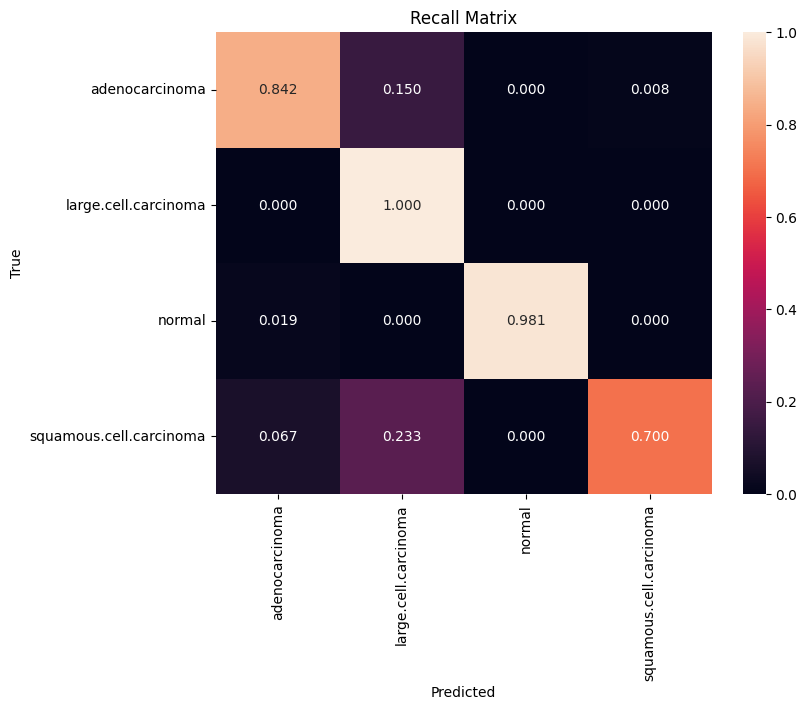

-------------------------------------------------- Precision Matrix --------------------------------------------------


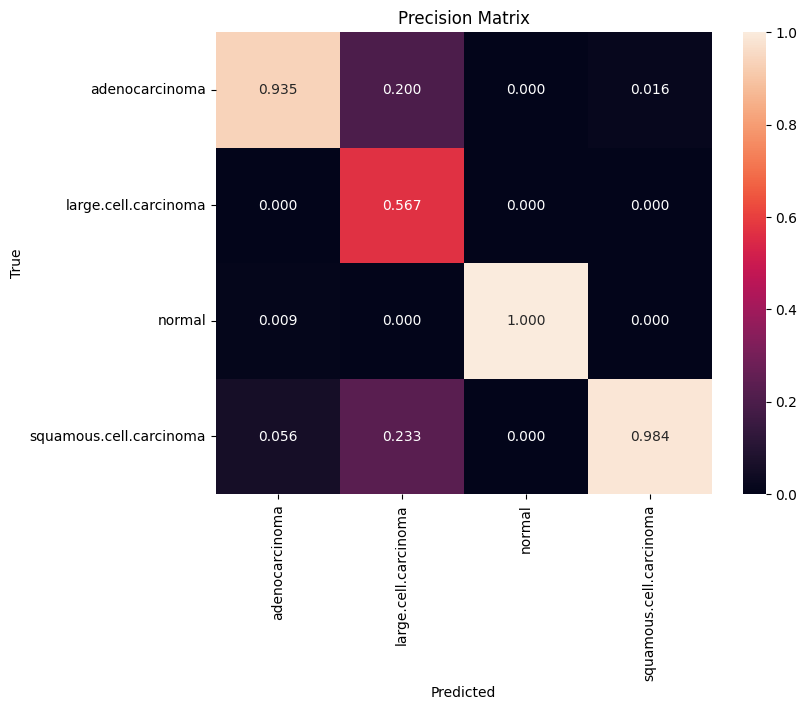

In [ ]:
# Recall Matrix
A = (((cm.T)/(cm.sum(axis=1))).T)
# Precision Matrix
B = (cm/cm.sum(axis=0))
print('-'*50,"Recall Matrix","-"*50)
plt.figure(figsize=(8, 6))
sns.heatmap(A, annot=True, fmt='.3f', xticklabels=np.unique(test_c), yticklabels=np.unique(test_c))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Recall Matrix')
plt.show()

print('-'*50,"Precision Matrix","-"*50)
plt.figure(figsize=(8, 6))
sns.heatmap(B, annot=True, fmt='.3f', xticklabels=np.unique(test_c), yticklabels=np.unique(test_c))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Precision Matrix')
plt.show()